### jokes detection with Deep Learning
A humor reconizer and the results for the GPT-2 model


In [1]:
!pwd

/Users/tsung-chin.han/ZDOC/Berkeley/w266/NLP-Final-Project-2020/Classifier


### 0 - Packages dependencies

In [ ]:
# import sys
# !{sys.executable} -m pip install tensorflow==1.15.0

In [2]:
# data
import pandas as pd
import numpy as np
import json

# plotting
from matplotlib import pyplot as plt
%matplotlib inline

# deep learning
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.layers import Conv3D, MaxPooling3D
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras import backend as K

# other
import requests


In [165]:
# tensorflow version check
print(tf.__version__)

1.15.0


### 1 - Data - traning data - reddit_jokes

In [3]:
df = pd.read_json('reddit_jokes.json')
print(df.shape)
df.head()

(194553, 4)


,body,id,score,title
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....
3,A Sunday school teacher is concerned that his ...,5tz2wj,1,"Brian raises his hand and says, “He’s in Heaven.”"
4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...


Check the distribution for the score for the jokes.

(array([1.93449e+05, 6.59000e+02, 2.42000e+02, 1.13000e+02, 4.90000e+01,
        2.40000e+01, 1.10000e+01, 3.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([    0. ,  4852.6,  9705.2, 14557.8, 19410.4, 24263. , 29115.6,
        33968.2, 38820.8, 43673.4, 48526. ]),
 <a list of 10 Patch objects>)

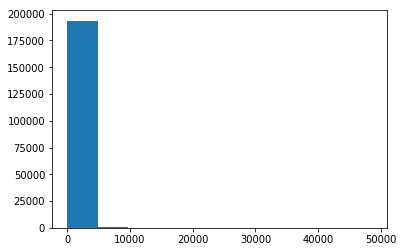

In [4]:
# orignial distributition
plt.hist(df.score)


In [5]:
df.score.describe()

count    194553.000000
mean        118.223255
std         936.231277
min           0.000000
25%           0.000000
50%           3.000000
75%          16.000000
max       48526.000000
Name: score, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194553 entries, 0 to 194552
Data columns (total 4 columns):
body     194553 non-null object
id       194553 non-null object
score    194553 non-null int64
title    194553 non-null object
dtypes: int64(1), object(3)
memory usage: 5.9+ MB


In [7]:
df.score.shape

(194553,)

In [100]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# scaler = StandardScaler()

# df.score = scaler.fit_transform(df.score)


In [8]:
print(df.score[df.score!=0].count()/df.score.shape[0])
print(df.score[df.score==0].count()/df.score.shape[0])
print(df.score[df.score >=100].count()/df.score.shape[0])


0.6835772257431137
0.3164227742568863
0.09641074668599302


label postive and negative jokes based on the score - form a binary label for us to model with.

In [9]:
# modeling score
df['is_funny'] = df.score.apply(lambda x: 1 if x > 1 else 0)


check the binary distribution

(array([ 80908.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 113645.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

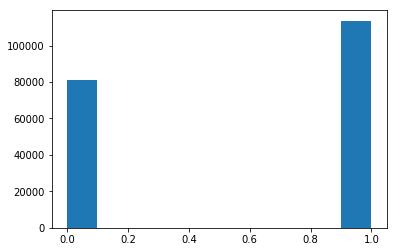

In [58]:
# modeling new binary distribution
plt.hist(df.is_funny)


Construct our tagert jokes format that are in line with our output from GPT-2 model.

In [11]:
# target
df['target'] = 'title: ' + df.title + ". " + "body: " + df.body
# df['target'] = df.title + ". " + df.body


Our final modeling data set

In [12]:
# finanl modeling dataset
final_modeling = df[['target', 'is_funny']]
print(final_modeling.shape)
final_modeling.head()


(194553, 2)


,target,is_funny
0,title: I hate how you cant even say black pain...,0
1,title: What's the difference between a Jew in ...,0
2,title: I recently went to America..... body: ....,0
3,"title: Brian raises his hand and says, “He’s i...",0
4,title: You hear about the University book stor...,0


In [13]:
final_modeling.is_funny.value_counts()

1    113645
0     80908
Name: is_funny, dtype: int64

In [16]:
# total sampels
print('total training samples: ',max(df.target.apply(lambda x: len(x))))


39757

### 2 - Preprocess Data

In [19]:
# sampel texts
texts = final_modeling.target.values

# tokenizing the data
maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # consider only top 10000 common words in our samples

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts) # texts to seq
word_index = tokenizer.word_index # index

print('found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen) # padding
labels = np.array(final_modeling.is_funny.values)

print('shape of data tensor:',data.shape)
print('shape of labels tensor:',labels.shape)


Found 98403 unique tokens


In [21]:
# shuffle the data that splits randomly for train and dev
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


### 3 - Loading the pre-trained word embeddings
(Note we are using glove embeeding for the classifier, as we take the input from the GPT-2 pre-trained)


In [36]:
# we would use standford's GloVe pre-trained word embeddings
# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-03-25 22:21:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-25 22:21:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-25 22:21:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [38]:
!unzip glove.6B.zip


Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Parsing the Glove embeddings

In [22]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors.'%len(embeddings_index))



Found 400000 word vectors:


Preparing Glove word embedding matrix

In [23]:
# preparing glove word embeddings matrix
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
            # for words not in embedding index values will be zeros


In [24]:
embedding_matrix.shape

(10000, 300)

### 4 - Training

In [25]:
# a - helper function for plotting the results
def plot_result(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1']
    val_f1 = history.history['val_f1']
  
    epochs = range(1, len(acc)+1)
        
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

    plt.figure()

    plt.plot(epochs, f1, label='Training f-measure')
    plt.plot(epochs, val_f1, label='Validation f-measure')
    plt.title('Training and validation f-measure')
    plt.xlabel('epochs')
    plt.ylabel('f1')
    plt.legend()

    plt.show()
    

In [ ]:
# b - helper for computing f1-measure as a metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


### 1 - feed-forward network with dense layers on top of embedding layer

In [302]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
flatten_8 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                960064    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 3,960,129
Trainable params: 3,960,129
Non-trainable params: 0
_________________________________________________________________


In [28]:
e = Embedding(max_words, embedding_dim, input_length=maxlen,\
              weights=[embedding_matrix], trainable=False)


In [26]:
import sys
!{sys.executable} -m pip install keras-self-attention


In [118]:
e = Embedding(max_words, embedding_dim, input_length=maxlen,\
              weights=[embedding_matrix], trainable=False)


In [139]:
# 2
# model = Sequential()
# model.add(e)
# model.add(Flatten())

# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3)) # adding regularization

# model.add(Dense(1, activation='sigmoid'))
# model.summary()


# model = Sequential()
# model.add(e)
# model.add(SimpleRNN(64, dropout=0.1))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()


from keras_self_attention import SeqSelfAttention
from keras.layers import Bidirectional


# model = Sequential()
# model.add(e)
# model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.3, return_sequences=True)))
# model.add(SeqSelfAttention(attention_activation='relu'))
# model.add(Flatten())
# model.add(Dense(1, activation='sigmoid'))
# model.summary()


model = Sequential()
model.add(e)
model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.3, return_sequences=True)))
# model.add(SeqSelfAttention(attention_activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 50, 128)           186880    
_________________________________________________________________
flatten_49 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 32)                204832    
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 33        
Total params: 3,391,745
Trainable params: 391,745
Non-trainable params: 3,000,000
_________________________________________________________________


In [306]:
# # load pre-trained word embeddings into the embedding layer and freeze it
# model.layers[0].set_weights([embedding_matrix])
# model.layers[0].trainable = False

In [140]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=10, batch_size=1000, validation_split=0.1)


# model.compile(optimizer=Adagrad(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
# history = model.fit(data, labels, epochs=15, batch_size=800, validation_split=0.1)



Train on 175097 samples, validate on 19456 samples
Epoch 1/10
175097/175097 [==============================] - 198s 1ms/step - loss: 0.6653 - acc: 0.5892 - f1: 0.7332 - val_loss: 0.6597 - val_acc: 0.6021 - val_f1: 0.7274
Epoch 2/10
175097/175097 [==============================] - 192s 1ms/step - loss: 0.6595 - acc: 0.6003 - f1: 0.7235 - val_loss: 0.6566 - val_acc: 0.6111 - val_f1: 0.7116
Epoch 3/10
175097/175097 [==============================] - 196s 1ms/step - loss: 0.6561 - acc: 0.6068 - f1: 0.7198 - val_loss: 0.6637 - val_acc: 0.5942 - val_f1: 0.6454
Epoch 4/10
175097/175097 [==============================] - 200s 1ms/step - loss: 0.6540 - acc: 0.6103 - f1: 0.7167 - val_loss: 0.6515 - val_acc: 0.6132 - val_f1: 0.7292
Epoch 5/10
175097/175097 [==============================] - 421s 2ms/step - loss: 0.6524 - acc: 0.6115 - f1: 0.7172 - val_loss: 0.6529 - val_acc: 0.6108 - val_f1: 0.7332
Epoch 6/10
175097/175097 [==============================] - 220s 1ms/step - loss: 0.6508 - acc: 0.6

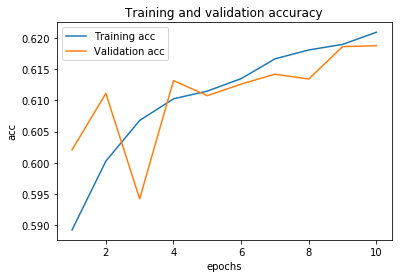

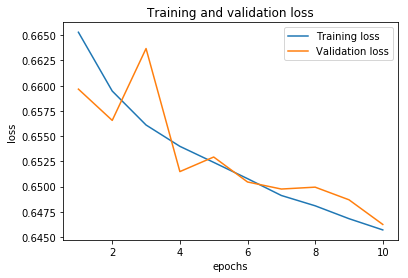

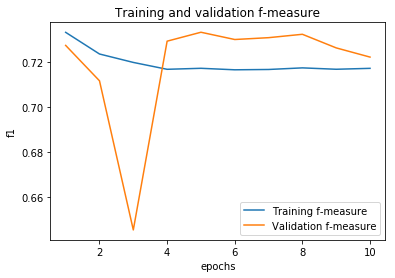

In [142]:
# plotting the results
plot_result(history)


In [235]:
# # save model
# model.save('model.h5')


In [236]:
# from keras.models import load_model

In [237]:
# model = load_model('model.h5')

### 5 - Prediction

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           3000000   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 50, 128)           186880    
_________________________________________________________________
flatten_49 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 32)                204832    
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 33        
Total params: 3,391,745
Trainable params: 391,745
Non-trainable params: 3,000,000
_________________________________________________________________


In [145]:
### c - helper function to make a post request from our flask server

def request_jokes(url, question):
    """
    """
    
    while True:
        data = {'joke_title': question}
        r = requests.post(url=url, data=data)
        ans = [r.text]
        if ans[0]=="Failed" or set(ans[0].split())==set(question.split()):
            r = requests.post(url=url, data=data)
            ans = [r.text]
        else:
            return ans

### d - helper to generate jokes and classify humorous or not         
def request_prediction(model, question):
    """
    """
    
    out = []
    for i in range(len(question)):
        
        # data to be sent to api 
        ans = request_jokes(url=url, question=question[i])

        ### tokenizing
        tokenizer.fit_on_texts(ans)
        token_seq = tokenizer.texts_to_sequences(ans) # text to seq
        token_seq_pad = pad_sequences(token_seq, maxlen=maxlen) # pad seq

        # process answer - after body
        if ans[0].partition(question[i])[-1][0:8] == '\n body:':
            ans_jokes = ans[0].partition(question[i])[-1].partition('body: ')[-1]
        else:
            ans_jokes = ans[0].partition(question[i])[-1]

        # concatenate contents with title + body
        content = "title: " + question[i] + " body: " + ans_jokes
        print(str([i+1])+"- jokes "+str(i+1)+": "+ content)

        # prepare results
        result = content, model.predict_classes(token_seq_pad)[0][0], model.predict_proba(token_seq_pad)[0][0]
        out.append(result)

    prediction_result = pd.DataFrame(out, columns=['jokes', 'is_funny', 'proba'])
    return prediction_result


Let's see 100 samples jokes titles

In [146]:
# question (jokes titles) list setup
question = ["""Why is it so hard to break up with a Japanese Girl? """,
            """Why did the chicken cross the road? """,
            """Why did the producers of 007 films use government debt to fund their newest film? """,
            """I feel so bad for the necrophiliac's sister. """,
            """What's the difference between you and a Calendar? """,
            """This guy proposed to his wife after walking away from a terrible car accident without a scratch. He said "Life's too short and it can end at any time." """,
            """Roses are red. """,
            """These reports of a major snowstorm hitting the Northeast don't concern me. """,
            """Those ads actually ran. """,
            """Burnt my Hawaiian pizza today. """,
            """I hate how you cant even say black paint anymore. """,
            """What's the difference between a Jew in Nazi Germany and pizza ? """, 
            """I recently went to America.... """,
            """Brian raises his hand and says, “He’s in Heaven.” """,
            """You hear about the University book store worker who was charged for stealing $20,000 worth of books? """,
            """Why is it unknown on how pterodactyls urinate especially during flight? """,
            """Why women need legs? """,
            """I walked into a PETA adoption center and the receptionist asked me what kind of dog I wanted """,
            """How did TV studios make words appear on screen before computers? """,
            """How do you find Will Smith in the snow? """, 
            """Remember when you were a kid and when you cried your parents said, "I'll give you a reason to cry"? """,
            """Remember, you can't spell Valentine's Day without... """,
            """Happy try not to jump off a bridge day! """,
            """My boss said to me, "you're the worst train driver ever. How many have you derailed this year?" """,
            """If I get a bird I'm naming it Trump """,
            """I was going to get a headjob for Valentines Day """,
            """A mother went into a coma after giving birth to twins """,
            """What do you call an exercise machine with a strobe light? """,
            """My dad has a heart of a lion """,
            """Smaller babies may be delivered by a stork. """,
            """A monkey is getting stoned in a zoo... """,
            """I've translated a popular Russian joke to English , wanna hear you reaction )) """,
            """What did the mommy bean say to her son when he asked for money? """,
            """When You Break Up At 11:59 Tonight """,
            """I wanted to buy an Audi. """,
            """I'm Trying to Remember The Name of A Song """,
            """What are minorities? """,
            """Did you hear that Donald Trump is technically a plant? """,
            """i had trouble swallowing a viagra last night """,
            """What is the king of all school supplies? """,
            """A rugby player was hurt very badly during a scrum and he had both of his ears ripped off... """,
            """A man was in his front yard mowing grass when his attractive blonde female !! """,
            """A woman runs into a doctor’s office and says “DOCTOR! DOCTOR! You have to help me! Everywhere I touch on my body it hurts!” """,
            """Why did the producers of 007 films use government debt to fund their newest film? """,
            """Pocket empty day ! """,
            """I want to see that new movie coming out with Scarlett Johannson… """,
            """Man gets lost in the desert. """,
            """Site of the 2017 Dane county massacre. """,
            """He fucked what? """,
            """My wife wants to eat somewhere shes never eaten before for V-Day """,
            """I was offered sex with a 21 yr old today """,
            """3 women talk """,
            """There are two types of people """,
            """Why did the computer squeak? """,
            """i found a place where the recycling rate is 98%. """,
            """Valentine's day fights """,
            """I feel so bad for the necrophiliac's sister """,
            """Julian Lennon messed up breakfast """,
            """I hear the Mexicans are planning an attack on America """,
            """I bought my friend an elephant for their room. """,
            """You're laughing because I'm laughing. """,
            """his guy proposed to his wife after walking away from a terrible car accident without a scratch. He said "Life's too short and it can end at any time." """,
            """First woman on mars. """,
            """Bad Advertisement """,
            """Those ads actually ran. """,
            """Why is the camel called the ship of the desert? """,
            """A Man Gets Really Drunk """,
            """What's the best thing about living in Switzerland? """,
            """A milestone """,
            """What part of the house got busted for drugs? """,
            """Relationships are a lot like algebra. """,
            """If Harry Potter were about pirates: """,
            """US Politics are """,
            """What's a ninjas favorite drink? """,
            """I used to hate the ballet """,
            """Life is like a diploma """,
            """ How do you encourage a bear to eat cheese? """,
            """Why was the orchestra teacher angry? """,
            """A fat man is watching television """,
            """In the beginning, God created the dog. """,
            """What's the quickest way to get in touch with your inner self? """,
            """What do you get when you combine Richard Simmons with Stephen Hawking? """,
            """A marketing executive walks into a bar """,
            """What do you call the presidential toilet? """,
            """Why is Tumblr bad for you? """,
            """What is the shittiest part of Object Oriented Programming? """,
            """Dad Joke """,
            """I love open-minded people. """,
            """Who came first. The chicken or the egg """,
            """Where do you find a dog with no legs? """,
            """What's the deal with airline food? """,
            """I like my soda like I like my women """,
            """What is the worst icebreaker? """,
            """What are your thoughts on monorails? """,
            """What's a pirate's favorite letter? """,
            """What do you call a rabbit roaming with a pack of lions? """,
            """How do you make a tissue dance? """,
            """I just got a haircut, but I'm not sure I like it. """,
            """How do you make Holy Water? """,
            """What's the most dangerous animal in the world? """       
            
            
           ]


In [53]:
# question = ["""Why is it so hard to break up with a Japanese Girl? """,
#             """Why did the chicken cross the road? """,
#             """I feel so bad for the necrophiliac's sister. """,
#             """What's the difference between you and a Calendar? """,
#             """These reports of a major snowstorm hitting the Northeast don't concern me. """,
#             """Those ads actually ran. """,
#             """Burnt my Hawaiian pizza today. """,
#             """I hate how you cant even say black paint anymore. """,   
#            ]


In [154]:
# check
print("total number of jokes:", len(question))


total number of jokes: 100


##### open flask app first and run below for the preudction results

In [148]:
# flask server url
url = "http://127.0.0.1:5000/generate"

# make predictions
prediction_result = request_prediction(model, question)


[1]- jokes 1: title: Why is it so hard to break up with a Japanese Girl?  body: 

A: A) I feel obligated
[2]- jokes 2: title: Why did the chicken cross the road?  body: 

Why did the egg cross the road? 

Because the other egg had a penis.
[3]- jokes 3: title: Why did the producers of 007 films use government debt to fund their newest film?  body:  

Because the film was in debt to the government.
[4]- jokes 4: title: I feel so bad for the necrophiliac's sister.  body:  You know how I feel when she dies in a car accident?"  She said, "Well, I should have paid attention that time."
[5]- jokes 5: title: What's the difference between you and a Calendar?  body: 

I can't just let you out of my sight.
[6]- jokes 6: title: This guy proposed to his wife after walking away from a terrible car accident without a scratch. He said "Life's too short and it can end at any time."  body: 
So he threw a huge party and invited everyone in the world, but no one knew he was gay and he was worried that ot

[45]- jokes 45: title: Pocket empty day !  body: 


"What do you do with all these tourists?" 

"I make them laugh."
[46]- jokes 46: title: I want to see that new movie coming out with Scarlett Johannson…  body: 

Then, I'm sorry I have a horrible car.
[47]- jokes 47: title: Man gets lost in the desert.  body: 

The husband tells his wife, "I don't know where I am, but I'm not going to get lost anymore"

"This ain't my fault" she answers

"You're not" says the husband"I'm just a guy who wants to be married and I don't even know where I am"
[48]- jokes 48: title: Site of the 2017 Dane county massacre.  body:  Source: the local newspaper.
[49]- jokes 49: title: He fucked what?  body: 

A cinderblock.
[50]- jokes 50: title: My wife wants to eat somewhere shes never eaten before for V-Day  body: !"


"No Problem!" says the man.
[51]- jokes 51: title: I was offered sex with a 21 yr old today  body: 
Body: 

I refused.
[52]- jokes 52: title: 3 women talk  body: 

2 women talk 

3 women talk 

[90]- jokes 90: title: Where do you find a dog with no legs?  body: 

(Not sure how to answer that, sorry.)

Source(s): [1]
[91]- jokes 91: title: What's the deal with airline food?  body:  Everyone knows it's just gravy
[92]- jokes 92: title: I like my soda like I like my women  body: 

'Cause when you're done I'm gonna go to your house and I'm gonna tell your wife: "I'm gonna fuck your daughter!"
[93]- jokes 93: title: What is the worst icebreaker?  body:  

The best icebreaker is also the worst.  

Why does the icebreaker drink so much?  

Because it has been a week since i left and its still early.  

How do you keep a good icebreaker from getting lost?  

By telling it the exact name of your hotel and asking it to tell the exact address.
[94]- jokes 94: title: What are your thoughts on monorails?  body: 

I'm a car person.
[95]- jokes 95: title: What's a pirate's favorite letter?  body: 

"BON."
[96]- jokes 96: title: What do you call a rabbit roaming with a pack of lions?  body: 

In [149]:
# output pandas dataframe
prediction_result


,jokes,is_funny,proba
0,title: Why is it so hard to break up with a Ja...,0,0.485252
1,title: Why did the chicken cross the road? bo...,0,0.420270
2,title: Why did the producers of 007 films use ...,1,0.522594
3,title: I feel so bad for the necrophiliac's si...,1,0.574645
4,title: What's the difference between you and a...,1,0.596912
5,title: This guy proposed to his wife after wal...,1,0.667338
6,title: Roses are red. body: \n\nThe sky is bl...,0,0.462938
7,title: These reports of a major snowstorm hitt...,1,0.804163
8,title: Those ads actually ran. body: The com...,1,0.704692
9,title: Burnt my Hawaiian pizza today. body: ...,1,0.675886


In [164]:
# humoruous percentage
prediction_result.is_funny.value_counts()[1]/len(prediction_result)


0.74